# 어텐션을 활용한 추상적 요약 모델 생성 및 평가 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; seq2seq 모델과 어텐션을 활용하여 문장 요약 모델을 생성하고 이를 추출적 요약과 비교하여 평가를 실시 하였다. 데이터는 뉴스 기사에 대한 원문과 제목을 이용하였으며, 데이터 분석과 데이터 전처리 과정을 진행하였다. 데이터 전처리 과정에서는 텍스트 정규화, 불용어 제거, html tag 제거, 패딩 추가 등의 작업을 시행하고 해당 데이터를 학습 데이터와 테스트 데이터로 분리하였다. 모델 평가에서는 임의의 다섯 문장에 대한 모델의 요약문과 추출적 요약의 요약문을 비교하였으며, 평가 지표로 문법이 틀린 개수인 '문법 오류 정도'와 동사와 명사 일치 개수인 '단어 일치 정도'를 사용하였으며, 그 결과 모델의 경우 평균 문법 오류 정도는 0.2였다. 단어 일치 정도는 1.8 이었으며, 추출적 요약의 평균 문법 오류 정도는 0이었으며, 단어 일치 정도는 3.6이었다. 추출적 요약의 경우가 더 잘 요약한 것이라 할 수 있지만, 추출적 요약의 경우 전혀 다른 문장을 제시하거나 하는 문제가 있고 추상적 요약의 경우 문장의 의미를 잘 요약한 점과 원문으로부터 새로운 문장을 생성한다는 점에서 개선의 여지가 있다고 할 수 있다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 어텐션을 활용하여 자연어 문장을 요약하는 추상적 요약 모델을 생성하고 이를 '추출적 요약'과 비교하여 평가하고자 합니다. '추상적 요약'은 문장으로부터 새로운 문장을 생성하여 원문을 요약하는 것입니다. '추출적 요약'은 원문의 문장을 그대로 이용하는 것입니다. 예제는 '뉴스 기사 데이터'를 데이터셋으로 이용 합니다. 예제 진행은 크게 '데이터 분석', '데이터 전처리', '추상적 모델 생성 및 학습', '추출적 요약과 비교한 모델 평가' 순으로 진행 됩니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 추상적 모델 생성 및 학습_
>
> _4. 추출적 요약과 비교한 모델 평가_


***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 분석 단계에서는 데이터 레코드 수, 어트리뷰트, 데이터 자료형 등의 기본적인 정보를 살펴 본 후, 좀 더 자세한 분석을 위해 '중복 데이터 제거', '텍스트 정규화 및 불용어 제거'와 같은 데이터 정제를 진행 합니다. 이후, 데이터의 결측 값 여부와 문장의 길이에 대한 통계를 살펴보고 최적의 문장 길이를 확보하고자 합니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제 진행에 필요한 라이브러리를 호출 합니다.
***

In [1]:
import pickle   #plk 파일 load
import numpy as np   #행렬 연산
import pandas as pd   #csv 파일 로드
import matplotlib.pyplot as plt   #시각화


import requests   #추출적 요약
from summa.summarizer import summarize   #추출적 요약2

import re   #정규식
import nltk   #자연어
nltk.download('stopwords')   #불용어
from nltk.corpus import stopwords   #불용어
from bs4 import BeautifulSoup   #마크업 용어 제거


import time   #멀티프로세싱 작업 소요 시간 체크
import multiprocessing as mp   #Multi Processing
from multiprocessing import Pool   #멀티프로세싱
from functools import partial   #map 함수 여러 인자


from tensorflow.keras.models import Model   #모델
from attention import AttentionLayer   #어텐션
from tensorflow.keras.preprocessing.text import Tokenizer   #토크나이저
from tensorflow.keras.preprocessing.sequence import pad_sequences   #패딩추가
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint   #콜백함수
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate   #모델 레이어

<br>

### 2.1. 데이터 기본 정보 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터의 기본 정보에 대해 알아봅니다. 데이터셋은 요약문(`headlins`)와 원문(`text`) 속성으로 구성되어 있으며, 영문 문장에 해당 합니다. 결측치는 없었으며, 총 레코드 수는 98,401개 입니다. 원문과 요약문의 중복을 제외한 데이터는 각각 98,360개, 98,280개 입니다.
</span>

***

#### 데이터 기본 정보
***
+ `headlines`, `text` 속성으로 구성되며, `headlines`는 '요약문', `text`는 '원문'으로 두 속성의 데이터 모두 자연어에 해당 합니다.


+ 두 속성의 데이터 모두 `NULL` 값은 없습니다.


+ 데이터 레코드는 총 98,401개 입니다.


+ `headlines` 고유 값은 총 98,280개, `text` 고유 값은 총 98,360개 입니다.
***

In [2]:
data = pd.read_csv('./dataset/news_summary_more.csv', encoding='iso-8859-1')   #csv 파일 불러오기


#출력부============================
print("*" * 60)
print("<DATA INFO>")
print(data.info())
print("*" * 60)

print("\n\n" + "*" * 60)
print("<DATA DESCRIBE>")
print(data.describe())
print("*" * 60)

data.head(5)
#End===============================

************************************************************
<DATA INFO>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None
************************************************************


************************************************************
<DATA DESCRIBE>
                                                headlines  \
count                                               98401   
unique                                              98280   
top     Why is England-Australia Test series called 'T...   
freq                                                    3   

                                                     text  
count                                               98401  
unique                                              

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


<br>

#### 데이터 샘플 확인
***
+ 요약문과 원문 샘플을 확인 합니다.

<br>

> __upGrad 학습자가 90% 급여 인상과 함께 ML 및 Al에서 경력으로 전환__

> 기계 학습 및 인공 지능 분야의 upGrad 및 IIIT-B PG 프로그램 졸업생인 Saurav Kant는 거의 5년 간의 업무 경험을 가진 Infosys의 수석 시스템 엔지니어였습니다. 이 프로그램과 upGrad의 360도 경력 지원은 그가 90%의 급여 인상과 함께 Tech Mahindra의 데이터 과학자로 전환하는 데 도움이 되었습니다. upGrad의 온라인 파워 러닝은 30만 이상의 경력을 쌓았습니다.
***

In [3]:
#출력부============================
print("*" * 60)
print("<HEADLINE SAMPLE>")
print(data["headlines"][0])
print("*" * 60)

print("\n\n" + "*" * 60)
print("<TEXT SAMPLE>")
print(data["text"][0])
print("*" * 60)
#End===============================

************************************************************
<HEADLINE SAMPLE>
upGrad learner switches to career in ML & Al with 90% salary hike
************************************************************


************************************************************
<TEXT SAMPLE>
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
************************************************************


<br>

### 2.2. 데이터 정제
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 조금더 자세한 분석을 위해 데이터 정제를 실시 합니다. 데이터 정제는 '원문 중복 데이터 제외', '텍스트 정규화', '불용어 제외', 'html 태그 제거' 등의 처리를 거칩니다. 중복 데이터 제거를 원문에 한해 시행하는 이유는 요약문은 중복되어도 원문이 다를 수 있기 때문에,
원문을 기준으로 중복 데이터를 제거 합니다.
</span>

***

#### 원문 중복 데이터 제외
***
+ '요약문'이 중복 되어도 '원문'은 다를 수가 있습니다.


+ 하지만 '원문'이 중복된 것은 같은 데이터가 두 개 이상 있는 것이니 제외 합니다.


+ `title`을 기준으로 중복 데이터를 제외하고 총 98,360개의 레코드를 획득 합니다.
***

In [4]:
data.drop_duplicates(subset = ['text'], inplace=True)   #'text' 기준 중복 데이터 제거


#출력부============================
print("*" * 60)
print("<DATA DESCRIBE>")
print(data.describe())
print("*" * 60)
#End===============================

************************************************************
<DATA DESCRIBE>
                                          headlines  \
count                                         98360   
unique                                        98262   
top     Don Bradman once scored 100 runs in 3 overs   
freq                                              3   

                                                     text  
count                                               98360  
unique                                              98360  
top     The UN has asked the UK to suspend work at the...  
freq                                                    1  
************************************************************


<br>

#### 텍스트 정규화
***
+ `it will`, `it'll` 또는 `is not`, `isn't`처럼 동일한 표현을 통합하여 처리 합니다.


+ 텍스트 정규화를 위한 사전을 'pickl' 파일로 저장하여, 필요 시에 불러와 사용 합니다.


+ 텍스트 정규화 대상 단어는 총 120개 입니다.


+ 텍스트 정규화 사전 데이터 중 5개를 출력 합니다.
***

In [5]:
#텍스트 정규화 사전 불러오기=============
with open('./dataset/contractions.pkl', 'rb') as f:
    contractions = pickle.load(f)
#End=====================================


#출력부============================
print("*" * 60)
for key, value in contractions.items():
    print("KEY: {0}\tVALUE: {1}".format(key, value))
    if key == "could've": break;
print("*" * 60)

print("contractions num:", len(contractions))
#End===============================

************************************************************
KEY: ain't	VALUE: is not
KEY: aren't	VALUE: are not
KEY: can't	VALUE: cannot
KEY: 'cause	VALUE: because
KEY: could've	VALUE: could have
************************************************************
contractions num: 120


<br>

#### 불용어 처리
***
+ 자주 쓰이지만 자연어 처리에 영향을 미치지 않는 '불용어'를 제외 합니다.


+ 불용어는 총 179개 입니다.


+ NLTK에서 제공하는 불용어 리스트 중 5개의 샘플을 출력 합니다.
***

In [6]:
#출력부============================
print("*" * 60)
for idx, word in enumerate(stopwords.words("english")):
    print(word)
    if idx == 5: break;
print("*" * 60)

print("stopwords num:", len(stopwords.words('english')))
#End===============================

************************************************************
i
me
my
myself
we
our
************************************************************
stopwords num: 179


<br>

#### 데이터 정제 함수 생성
***
+ 전체 문장 소문자로 변경, html 태그 제거, 특수문자 제거 등의 정제 함수를 생성 합니다.


+ '원문'에 대해서만 불용어를 제거하고 '요약문'에서는 불용어를 포함하기 위해 `remove_stopwords`를 매개변수로하여 불용어 제외 여부를 선택 합니다.
***

In [7]:
# 데이터 전처리 함수===================
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    if remove_stopwords:   #불용어 제거 여부
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:   #불용어 미제거 (Summary)
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
#End===================================


#여러 문장에 대한 전처리===============
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts
#End===================================


#출력부================================
text = "You need cooling, Baby I'm not fooling."   #Whole Lotta Love - Led Zeppelin / 1969
print("*" * 60)
print(text)
print("↓" * 20)
print(appendTexts([text], True))
print("*" * 60)
#End==================================

************************************************************
You need cooling, Baby I'm not fooling.
↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
['need cooling baby fooling']
************************************************************


<br>

#### 멀티프로세싱 데이터 정제 함수 생성
***
+ 다량의 데이터를 정제 해야하므로 멀티프로세싱을 이용하여 시간을 단축 합니다.
***

In [8]:
def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬 처리
    pool = Pool(num_cores)

    processed_data = np.concatenate(   # 각자 작업한 데이터 합치기
        pool.map(
            partial(appendTexts, remove_stopwords=remove_stopwords),
            text_data_split
        )
    )  
    pool.close()
    pool.join()
    print("Data cleaning: ", round(time.time() - start_time, 2), " seconds")
    return processed_data

<br>

#### 데이터 정제 실시
***
+ 앞서 생성한 함수를 바탕으로 데이터 정제를 실시 합니다.


+ 원문 즉, `text` 데이터는 불용어를 제거하고, 요약문인 `headlines` 데이터는 불용어를 제거하지 않습니다.
***

In [9]:
#데이터 정제 실시==================
print("*" * 50)
print("Start `text` data cleaning...")
clean_text = preprocess_data(data['text'])
print("Done `text` data cleaning...")
print("*" * 50)

print("\n\n" + "*" * 50)
print("Start `summary` data cleaning...")
clean_summary = preprocess_data(data['headlines'], remove_stopwords=False)
print("Done `summary` data cleaning...")
print("*" * 50)
#End===============================

#정제 데이터로 대체================
data['text'] = clean_text
data['headlines'] = clean_summary
#End===============================


#출력부============================
print("\n\n" + "*" * 60)
print("<HEADLINE SAMPLE>")
print(clean_text[0])
print("*" * 60)

print("\n\n" + "*" * 60)
print("<TEXT SAMPLE>")
print(clean_summary[0])
print("*" * 60)
#End===============================

**************************************************
Start `text` data cleaning...
Data cleaning:  415.13  seconds
Done `text` data cleaning...
**************************************************


**************************************************
Start `summary` data cleaning...
Data cleaning:  12.73  seconds
Done `summary` data cleaning...
**************************************************


************************************************************
<HEADLINE SAMPLE>
saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
************************************************************


************************************************************
<TEXT SAMPLE>
upgrad learner switches to career in ml al with salary hike
*****************************************

<br>

### 2.3. 정제 후 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 조금 더 자세한 데이터 분석을 실시 합니다. 데이터 정제를 실시 하였기 때문에 결측지를 다시 확인 한 결과, 결측치는 발견되지 않았습니다. 이후의 모델이 입력 받을 문장의 길이를 설정하기 위해 최적의 문장 길이를 판단하기 위해, 데이터셋의 문장 길이를 분석하였습니다. 원문(text)의 경우 최대 60개의 단어로 구성된 문장이 존재하며, 평균 35개의 단어로 문장이 이루어져 있음을 확인하였습니다. 요약문(headlines)의 경우 최대 16개의 단어로 구성된 문장이 존재하며 평균 9개의 단어로 문장이 이루어져 있음을 확인하였습니다. 또한, 원문의 경우 40개 이하의 단어로 구성된 문장이 약 92.4%이며, 요약문의 경우 11개 이하의 단어로 구성된 문장이 약 94.5%인 것을 확인하였습니다.
</span>

***

#### NULL 값 확인
***
+ 데이터 정제 후 `NULL` 값을 확인 합니다.

+ `text`, `headlines` 모두 `NULL` 값이 존재하지 않습니다.
***

In [10]:
data.replace('', np.nan, inplace=True)   #빈 값을 Null 값으로 변환


#출력부============================
print("*" * 60)
print("<DATA INFO>")
print(data.info())
print("*" * 60)
#End==============================

************************************************************
<DATA INFO>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98360 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98360 non-null  object
 1   text       98360 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None
************************************************************


<br>

#### 문장 길이 분석
***
+ 원문 즉, `text`의 경우 하나의 단어로 구성된 데이터가 존재 하며, 최대 60개의 단어로 구성된 문장이 존재하고 평균 약 35개의 단어로 문장이 이루어져 있습니다.


+ 요약문 즉, `headlines`의 경우 하나의 단어로 구성된 데이터가 존재 하며, 최대 16개의 단어로 구성된 문장이 존재하고 평균 약 9개의 단어로 문장이 이루어져 있습니다.
***

************************************************************
text min len: 1
text max len: 60
text avg len: 35.09968483123221

headline min len: 1
headline max len: 16
headline avg len: 9.299532330215534
************************************************************


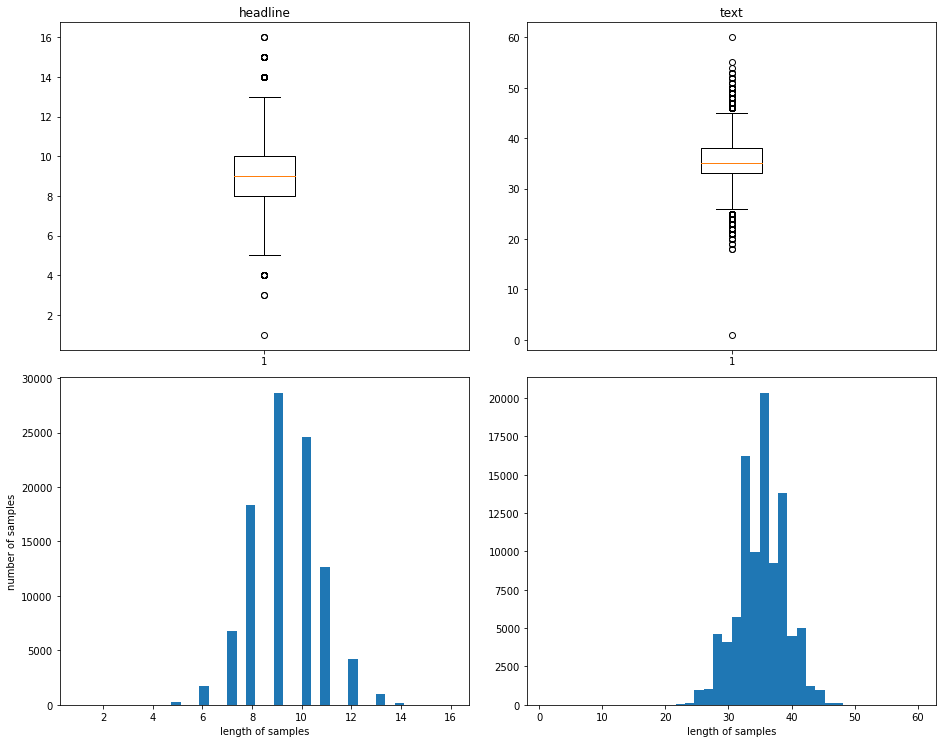

In [11]:
text_len = [len(s.split()) for s in data['text']]   #원문에 대한 문장 길이
summary_len = [len(s.split()) for s in data['headlines']]   #요약문에 대한 문장 길이


#출력부============================
print("*" * 60)
print('text min len: {}'.format(np.min(text_len)))
print('text max len: {}'.format(np.max(text_len)))
print('text avg len: {}'.format(np.mean(text_len)))

print('\nheadline min len: {}'.format(np.min(summary_len)))
print('headline max len: {}'.format(np.max(summary_len)))
print('headline avg len: {}'.format(np.mean(summary_len)))
print("*" * 60)
#End==============================


#시각화===========================
plt.figure(figsize=(7, 10))
plt.subplot(2,2,1)
plt.boxplot(summary_len)
plt.title('headline')

plt.subplot(2,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()

plt.subplots_adjust(right=1.8)

plt.subplot(2,2,3)
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(2,2,4)
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.show()
#End==============================

<br>

#### 최적 문장 길이 확보하기
***
+ 원문의 경우 40개 이하의 단어로 구성된 문장이 약 92.4%를 이룹니다.


+ 요약문의 경우 11개 이하의 단어로 구성된 문장이 약 94.5%를 이룹니다.
***

In [12]:
#문장 길이에 따른 데이터 비율 확인 함수=============
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    return round(cnt/ len(nested_list), 3)
#End================================================


#출력부============================
text_max_len, summary_max_len = 40, 11

print("*" * 60)
print("40 len text record:", below_threshold_len(text_max_len, data["text"]))
print("11 len headlines record:", below_threshold_len(summary_max_len, data["headlines"]))
print("*" * 60)
#End==============================

************************************************************
40 len text record: 0.924
11 len headlines record: 0.945
************************************************************


<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 전처리 단계에서는 앞서 실시한 분석을 바탕으로 문장 길이에 따른 데이터를 제외 하거나 단어 사전을 생성하여 문장을 토큰화 하는 등의 학습 데이터로 사용할 수 있게 데이터를 수정합니다. 특히, 문장의 단어 수를 데이터의 약 90%의 비중을 차지하는 원문은 40개, 요약문은 11개 이하의 단어로 구성된 문장만 확보 합니다. 최종적으로 학습 데이터 68,675개, 테스트 데이터 17,168개를 확보 하였습니다.
</span>

***

### 3.1. 데이터 전처리를 통한 학습 데이터 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 분석 단계에서 획득한 각 데이터에 대한 문장 길이를 바탕으로 원문은 40개 단어 초과, 요약문은 11개 단어 초과 문장을 제외 합니다. 이후, 모델이 문장을 예측 할 수 있도록 시작과 종료 토큰을 추가하여 줍니다. 또한, 데이터를 학습 데이터와 테스트 데이터로 분리하여 줍니다. 최종적으로 학습 데이터 68,675개, 테스트 데이터 17,168개를 획득 하였습니다.
</span>

***

#### 문장길이에 따른 데이터 제외
***
+ 앞서 획득한 원문과 요약문에 대한 문장 길이를 바탕으로 해당 문장 길이보다 긴 문장은 제외 합니다.


+ 원문(`text`)은 40개 단어 초과, 요약문(`headlines`)은 11개 단어 초과 문장을 제외 합니다.


+ 총 85,843개의 레코드를 획득 하였습니다.
***

In [13]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]   #원문
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]   #요약문


#출력부============================
print("*" * 60)
print("<DATA INFO>")
print(data.info())
print("*" * 60)
#End==============================

************************************************************
<DATA INFO>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85843 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  85843 non-null  object
 1   text       85843 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None
************************************************************


<br>

#### 시작 · 종료 토큰을 추가한 디코더용 데이터 추가
***
+ 시작 토큰(`sostoken`)과 종료 토큰(`eostoken`)을 추가한 데이터를 생성하고 디코더 모델에 입력할 새로운 속성을 추가 합니다.
***

In [14]:
#토큰 추가 및 속성 추가============
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
#End===============================


#출력부===========================
data.head(3)
#End==============================

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...


<br>

#### 데이터 셔플링
***
+ 올바른 학습을 위해 데이터를 섞어 줍니다.
***

In [15]:
#Numpy로 변환========================
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
#End=================================


#데이터 shuffle======================
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)   #idx 섞기

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
#End=================================

<br>

#### 학습 데이터와 테스트 데이터 분리 하기
***
+ 학습 데이터 68,675개, 테스트 데이터 17,168개로 분리 하였습니다.
***

In [16]:
n_of_val = int(len(encoder_input) * 0.2)   #20% 분할


#학습 데이터======================
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
#End==============================


#테스트 데이터====================
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]
#End==============================


#출력부===========================
print("*" * 60)
print(
    "train X data num:", len(encoder_input_train),
    "\ttrain Y data num:", len(decoder_input_train)
)

print(
    "test X data num:", len(encoder_input_test),
    "\ttest Y data num:", len(decoder_input_test)
)
print("*" * 60)
#End==============================

************************************************************
train X data num: 68675 	train Y data num: 68675
test X data num: 17168 	test Y data num: 17168
************************************************************


<br>

### 3.2. 단어 사전 생성 및 문장 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 문장을 모델이 이해할 수 있도록 토큰화 해줍니다. 따라서, 우선적으로 단어사전을 생성하여 줍니다. 또한, 단어 사용빈도를 확인하여, 등장 빈도가 약 3% 이하인 단어는 제외하여 단어사전을 생성합니다. 이러한 과정을 원문과 요약문 별로 진행합니다.
</span>

***

### 3.2.1. 원문에 대한 문장 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 원문에 대한 토큰화를 진행합니다. 단어 사용빈도를 확인하여 22,000개의 단어로 단어사전을 생성합니다. 이후 자연어로 되어있는 문장을 토큰화 하여 줍니다.
</span>

***

#### 단어 사용 빈도 확인 하기
***
+ 전체 단어는 총 64,776개 입니다.


+ 전체 데이터에서 5회 이하 사용된 단어의 수는 42,389개 이며, 약 3.33% 빈도로 사용 되었습니다.


+ 6회 이상 사용된 단어는 총 22,387개로 해당 단어 만으로 다시 단어사전을 재정의 하고자 합니다.
***

In [17]:
#단어 사용 빈도 확인==============
def print_word_rate(tokenizer, word_num):
    threshold = word_num
    total_cnt = len(tokenizer.word_index)   #단어 빈도
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value


    #출력부===========================
    print("*" * 60)
    print('단어 집합(vocabulary)의 크기 :', len(tokenizer.word_index))
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    print("*" * 60)
    #End==============================
    
    return None
#End==============================


#토크나이저=======================
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) #학습 데이터 토큰화
#End==============================


print_word_rate(src_tokenizer, 6)

************************************************************
단어 집합(vocabulary)의 크기 : 64767
등장 빈도가 5번 이하인 희귀 단어의 수: 42476
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22291
단어 집합에서 희귀 단어의 비율: 65.58278135470223
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.354488677920944
************************************************************


<br>

#### 단어사전 생성
***
+ 총 22,000개의 단어가 등록된 단어사전을 생성 합니다.
***

In [18]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=20000) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

<br>

#### 문장을 토큰으로 변환 하기
***
+ 단어 사전을 기반으로 학습 데이터와 테스트 데이터를 토큰으로 변환 합니다.
***

In [19]:
print("*" * 60)
print(encoder_input_train[0])   #변환 이전 샘플


#토큰으로 변환 과정==========
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
#End=========================


print("↓" * 35)
print(encoder_input_train[0])   #변환 이후 샘플
print("*" * 60)

************************************************************
chechen republic leader ramzan kadyrov proposed death penalty recruiters terrorist groups recruiters must bear stronger punishment terrorist starts clockwork bomb someone takes hostages commits acts sabotage added earlier kadyrov claimed militants cannot cured destroyed
↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
[16198, 1960, 98, 9207, 15441, 735, 155, 1384, 19192, 1022, 1113, 19192, 654, 3015, 5093, 2658, 1022, 4305, 1243, 851, 1729, 13646, 3738, 12237, 4, 33, 15441, 40, 903, 229, 13647, 2235]
************************************************************


<br>

### 3.2.2. 요약문에 대한 문장 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 요약문에 대한 토큰화를 진행합니다. 단어 사용빈도를 고려하여 12,000개의 단어로 단어사전을 생성합니다. 이후 자연어로 되어있는 문장을 토큰화 하여 줍니다.
</span>

***

#### 단어 사용 빈도 확인 하기
***
+ 전체 단어는 총 28,526개 입니다.


+ 전체 데이터에서 3회 이하 사용된 단어의 수는 16,220개 이며, 약 3.52% 빈도로 사용 되었습니다.


+ 4회 이상 사용된 단어는 총 12,306개로 해당 단어 만으로 다시 단어사전을 재정의 하고자 합니다.
***

In [20]:
#토크나이저=======================
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
#End==============================


print_word_rate(tar_tokenizer, 4)

************************************************************
단어 집합(vocabulary)의 크기 : 28529
등장 빈도가 3번 이하인 희귀 단어의 수: 16207
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12322
단어 집합에서 희귀 단어의 비율: 56.80886115882085
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5269640934063173
************************************************************


<br>

#### 단어사전 생성
***
+ 총 12,000개의 단어가 등록된 단어사전을 생성 합니다.
***

In [21]:
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

<br>

#### 문장을 토큰으로 변환 하기
***
+ 단어 사전을 기반으로 학습 데이터와 테스트 데이터를 토큰으로 변환 합니다.
***

In [22]:
print("*" * 60)
print(decoder_input_train[0])   #변환 이전 샘플


#토큰으로 변환 과정==========
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)   #디코더 학습 X
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)   #디코더 학습 Y
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)   #디코더 테스트 X
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)   #디코더 테스트 Y
#End=========================


print("↓" * 35)
print(decoder_input_train[0])   #변환 이후 샘플
print("*" * 60)

************************************************************
sostoken give death penalty to terrorist recruiters chechen leader
↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
[1, 265, 86, 1017, 3, 1006, 10812, 120]
************************************************************


<br>

### 3.3. 데이터 전처리를 통한 학습 데이터 생성2
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 최종적으로 비어 있는 데이터를 제외하여 주고 문장에 패딩을 추가합니다. 원문의 최대 길이는 40, 요약문의 최대 길이는 11로 설정하고 문장의 뒷 부분에 패딩을 추가합니다.
</span>

***

#### 빈 데이터 삭제하기
***
+ 시작(`sostoken`) 또는 종료(`eostoken`) 토큰만 남아 길이가 1인 문장은 제외해 줍니다.
***

In [23]:
#토큰으로 변환된 데이터 중 문장의 길이가 1인 것만 리스트화=====
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
#End===========================================================


#길이가 1인 문장 제거하기======================================
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)   #인코더 학습 X
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)   #디코더 학습 X
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)   #디코더 학습 Y

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)   #인코더 테스트 X
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)   #디코더 테스트 X
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)   #디코더 테스트 Y
#End===========================================================


#출력부=======================
print("*" * 60)
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))
print("*" * 60)

print("\n\n" + "*" * 60)
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))
print("*" * 60)
#End==========================

************************************************************
삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
************************************************************


************************************************************
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168
************************************************************


<br>

#### 패딩 추가 하기
***
+ 원문은 최대 길이 40, 요약문은 최대 길이 11로 설정하여 패딩을 추가 합니다.
***

In [24]:
#패딩추가 text_max_len: 40, summary_max_len: 11
padding = "post"
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding=padding)
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding=padding)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding=padding)
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding=padding)
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding=padding)
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding=padding)


#출력부==================
print("*" * 60)
print(encoder_input_train[0])
print("*" * 60)
#End=====================

************************************************************
[16198  1960    98  9207 15441   735   155  1384 19192  1022  1113 19192
   654  3015  5093  2658  1022  4305  1243   851  1729 13646  3738 12237
     4    33 15441    40   903   229 13647  2235     0     0     0     0
     0     0     0     0]
************************************************************


<br>

## 4. 모델 설계 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서는 seq2seq에 어텐션을 결합한 형태의 모델을 사용 합니다. 어텐션은 RNN의 장기 의존성 문제를 해결하고자 인코더의 상태를 전부 반영할 수 있도록 해줍니다. 모델은 크게 seq2seq에 해당하는 인코더와 디코더로 구분되고 어텐션 레이어가 존재 합니다. [그림 1]은 어텐션을 결합한 seq2seq 모델을 시각화 한 것입니다.
</span>

<br><br>

<img src="./img/model.png" width=800></img>

[그림 1] 어텐션을 결합한 seq2seq 모델
***

#### 인코더 설계
***
+ 원문은 최대 길이 40, 요약문은 최대 길이 11로 설정하여 패딩을 추가 합니다.
***

In [25]:
embedding_dim = 128   #임베딩 벡터 크기
hidden_size = 256   #유닛 수


#Encoding Model=======================
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
#End==================================

<br>

#### 디코더 설계
***
+ 원문은 최대 길이 40, 요약문은 최대 길이 11로 설정하여 패딩을 추가 합니다.
***

In [26]:
#Decoding Model=======================
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
#End==================================

<br>

#### 어텐션 및 출력부 설계
***
+ 원문은 최대 길이 40, 요약문은 최대 길이 11로 설정하여 패딩을 추가 합니다.
***

In [27]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

<br>

#### 모델 통합 하기
***
+ 원문은 최대 길이 40, 요약문은 최대 길이 11로 설정하여 패딩을 추가 합니다.
***

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

<br>

## 5. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 생성한 모델을 학습하여 줍니다. 옵티마이저로 'Adagrad'의 학습률이 급격하게 줄어드는 문제를 해결하기 위해 G. Hintion이 제시한 'RMSProp'를 사용합니다. 또한 콜백함수를 사용하여 검증 데이터에 대한 손실 값이 2회 이상 증가할 경우 학습을 조기종료 합니다.
</span>

***

<br>

#### 모델 학습
***
+ 옵티마이저로 `rmsprop`을 사용 합니다.


+ `EarlyStopping`을 통해 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회 관측되면 학습을 조기종료 합니다.

<br>

> RMSProp는 G. Hinton이 제안한 것으로 AdaGrad의 시간이 지날수록 학습률이 급격하게 감소하는 문제가 존재하여,
이를 해결하기 위해 이전 변화량과 현재 변화량의 지수 평균으로 학습률이 급격하게 
감소하는 것을 방지하는 옵티마이저이다[1].
***

In [29]:
#모델 컴파일=========================
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy'
)
#End=================================


#콜백 함수===========================
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
#End=================================


#모델 학습===========================
history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test],decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=32
)
#End=================================

Epoch 1/32
269/269 [==============================] - 79s 263ms/step - loss: 6.5701 - val_loss: 5.7224
Epoch 2/32
269/269 [==============================] - 70s 261ms/step - loss: 5.6912 - val_loss: 5.3964
Epoch 3/32
269/269 [==============================] - 71s 263ms/step - loss: 5.2901 - val_loss: 5.0742
Epoch 4/32
269/269 [==============================] - 71s 264ms/step - loss: 4.9858 - val_loss: 4.8832
Epoch 5/32
269/269 [==============================] - 71s 263ms/step - loss: 4.7399 - val_loss: 4.7277
Epoch 6/32
269/269 [==============================] - 71s 264ms/step - loss: 4.5318 - val_loss: 4.5996
Epoch 7/32
269/269 [==============================] - 71s 263ms/step - loss: 4.3565 - val_loss: 4.4894
Epoch 8/32
269/269 [==============================] - 71s 264ms/step - loss: 4.1946 - val_loss: 4.4135
Epoch 9/32
269/269 [==============================] - 71s 262ms/step - loss: 4.0640 - val_loss: 4.3396
Epoch 10/32
269/269 [==============================] - 71s 263ms/step - l

<br>

#### 학습 결과 시각화
***
+ 학습 데이터와 검증 데이터에 대한 학습 진행에 따른 손실 값을 시각화 한 것입니다.
***

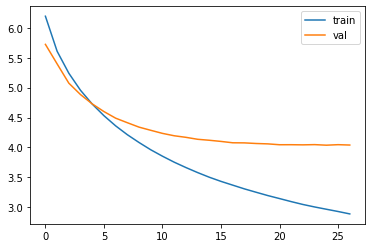

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

<br>

## 6. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습이 완료된 모델을 평가하고자 합니다. 우선, 학습데이터에 대한 손실 값은 2.836이며, 검증 데이터에 대한 손실 값은 4.04 입니다. 임의의 5개 문장을 사용하여, 어텐션 모델의 추상적 요약을 추출적 요약과 비교하여 모델을 평가하고자 합니다. 평가지표는 '문법 오류 정도'와 '단어 포함 정도'를 사용하고자 합니다.
</span>

***

### 6.1. 인퍼런스 단계 모델 및 필요 함수 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 요약문이 존재하지 않는 문장을 요약하기 위한 인퍼런스 단계의 모델을 생성합니다. 또한, 토큰으로 되어있는 문장을 자연어로 변경하기 위한 함수를 생성합니다.
</span>

***

#### 인퍼런스 단계의 모델 생성
***
+ 모델의 테스트 단계에서 사용할 모델을 생성 해 줍니다.
***

In [31]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

<br>

#### 필요 함수 생성
***
+ 모델이 출력한 토큰으로 된 문장을 다시 자연어로 변환하기 위한 함수를 생성 합니다.
***

In [32]:
#단어 사전===============================
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음
#End=====================================


#단어 시퀀스 함수========================
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
#End=====================================


# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환=====
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp
#End============================================


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환===
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp
#End============================================

<br>

### 6.2. 추상적 요약과 추출적 요약을 비교한 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 임의의 문장 다섯 개와 그에 대한 추출적 요약과 추상적 요약을 출력하여 이를 토대로 모델을 평가하고자 합니다. 평가지표는 '문법 오류 정도'와 '단어 포함 정도'를 사용하고자 합니다. 문법 오류 정도를 파악하기 위해 Superrrokie' 사이트의 문법 검사기를 사용하였습니다(https://www.superookie.com/en-grammarcheck). 해당 문법 검사기에서 지적한 개수를 문법 오류 정도로 사용 하였습니다. 또한 단어 일치 정도를 판단하기 위해 실제 요약문의 동사 및 명사와 모델 요약문의 동사 및 명사의 일치 개수를 사용 하였습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 그 결과 다섯 문장에 대한 어텐션 모델의 요약문의 평균 문법 오류 정도는 0.2였으며, 단어 일치 정도는 1.8 이었습니다. 추출적 요약의 평균 문법 오류 정도는 0이었으며, 단어 일치 정도는 3.6입니다. 평가 지표를 토대로 추상적 요약과 추출적 요약을 비교하였을 때, 추출적 요약이 더 잘 요약한 것이라 판단할 수 있습니다. 그러나 추출적 요약이 전혀 다른 문장을 제시하거나 하는 문제가 발생기도 하였습니다. 또한, 추상적 요약의 경우, 원문을 바탕으로 새로운 문장을 제시한다는 점과 원문의 의미를 잘 요약한 경우가 있기 때문에, 충분히 개선의 여지가 있다고 할 수 있습니다. 다음은 세 원문과 요약문에 대한 추상적 요약과 추출적 요약 결과를 보여줍니다.
</span>

***

<br>

***
> __Infosys, 전 CFO Bansal에 이자와 함께 12.17크루를 지불하라고 지시__

> Infosys는 전 CFO인 Rajiv Bansal에게 1217만 7천 파운드의 미지급 퇴직금을 이자와 함께 지불하라는 중재 재판소의 지시를 받았습니다. Infosys는 이전에 지불한 퇴직금 520만 파운드와 손해 배상액의 환불에 대한 반소가 기각되었다고 회사 서류에서 밝혔습니다. 2015년 인포시스를 그만둔 Bansal은 퇴직금으로 1738만 달러를 받을 예정이었습니다.

> _인포시스 회장, 전 CFO에 10억 달러 자산 지급(추상적 요약)_

> _2015년 인포시스를 그만둔 Bansal은 퇴직금으로 1738만 달러를 받을 예정이었습니다(추출적 요약)._

> __평가: 추상적 요약의 경우, 원문으로부터 새로운 문장을 생성하였으며 그 의미도 매우 잘 요약 하였다.__

<br><br>

> __캐터필라와 같은 로봇은 인체 내부에 약물을 전달할 수 있습니다__

> 연구자들은 인체 내부에 약물을 전달할 수 있는 애벌레 같은 다리를 가진 작고 부드러운 로봇을 개발했습니다. 17mm 길이의 다족 로봇은 전자기력을 사용하여 가혹한 환경을 통과합니다. 연구원들은 장애물을 넘을 때 최대 90도까지 서 있을 수 있으며 자신보다 100배 더 무거운 짐을 들 수 있다고 주장했습니다.

> _과학자들은 인간의 두뇌에 인간 로봇을 찾습니다(추상적 요약)._

> _연구자들은 인체 내부에 약물을 전달할 수 있는 애벌레 같은 다리를 가진 작고 부드러운 로봇을 개발했습니다(추출적 요약)._

> __평가: 추상적 요약의 경우 문법의 문제는 존재하지 않지만 문장의 의미를 이해할 수 없다.__

<br><br>

> __구글, 애플 모바일 칩 디자이너 영입__

> 거대 기술 기업인 Google은 거의 8년 동안 회사의 칩 개발에 참여한 Apple 마이크로 아키텍트 Manu Gulati를 고용했습니다. Google은 현재 Qualcomm을 사용하는 Pixel 스마트폰과 함께 모든 제품에 타사 칩에 의존하고 있습니다. 보고서에 따르면 이 회사는 Pixel 휴대전화용 CPU를 자체 설계하는 것을 목표로 Gulati를 고용했습니다.

> _구글은 플레이 지원을 위해 구글을 고용한다(추상적 요약)_

> _거대 기술 기업인 Google은 거의 8년 동안 회사의 칩 개발에 참여한 Apple 마이크로 아키텍트 Manu Gulati를 고용했습니다(추출적 요약)._

> __평가: 추상적 요약의 경우 새로운 인원을 고용하는 것을 잘 요약하였지만, 누구를 고용하는 가에 있어 올바르게 설명하지 못하였다.__
***

In [36]:
data = pd.read_csv('./dataset/news_summary_more.csv', encoding='iso-8859-1')   #csv 파일 불러오기
idx_list = np.random.randint(0, len(data), size=100)

print_count = 0
for idx in idx_list:
    text = data["text"][idx]
    headline = data["headlines"][idx]
    
    token_text = src_tokenizer.texts_to_sequences([text])
    token_text = pad_sequences(token_text, maxlen=text_max_len, padding="post")
    attention_text = decode_sequence(token_text.reshape(1, text_max_len))
    extractive_text= summarize(text, words=11)
    
    if not extractive_text: continue;
    print_count += 1
    
    print("\n\n\n\n" + "+" * 80)
    print("<TEXT>\n\t{0}\n".format(text))   #원문
    
    print("." * 60, "\n")
    
    print("<HEADLINE>\n\t{0}\n".format(headline))
    
    print("." * 60, "\n")
    
    print("<ATTENTION HEADLINE>\n\t{0}\n".format(attention_text))
    
    print("." * 60, "\n")
    
    print("<EXTRACTIVE HEADLINE>\n\t{0}\n".format(summarize(text, words=11)))
    
    print("+" * 80)
    if print_count > 4: break;





++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
<TEXT>
	Infosys has been directed by an arbitral tribunal to pay former CFO Rajiv Bansal an outstanding severance pay of Ã¢ÂÂ¹12.17 crore with interest. Infosys' counterclaim for a refund of previously paid severance amount of Ã¢ÂÂ¹5.2 crore and damages, has been rejected, a company filing said. Bansal, who quit Infosys in 2015, was supposed to get Ã¢ÂÂ¹17.38 crore in severance pay.

............................................................ 

<HEADLINE>
	Infosys told to pay Ã¢ÂÂ¹12.17 cr with interest to ex-CFO Bansal

............................................................ 

<ATTENTION HEADLINE>
	 infosys chairman to pay crore in assets to ex cfo

............................................................ 

<EXTRACTIVE HEADLINE>
	Bansal, who quit Infosys in 2015, was supposed to get Ã¢ÂÂ¹17.38 crore in severance pay.

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<br>

## 8. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 어텐션을 결합한 seq2sqe 문장 요약 모델 생성 및 학습하고 이를 추출적 모델의 요약문과 비교하여 평가해 보았습니다. 평가는 임의의 다섯 문장에 대한 어텐션 모델의 요약과 추출적 요약을 비교하였으며, 평가 지표로 '문법 오류 정도'와 '단어 일치 정도'를 사용하였습니다.
추상적 요약 모델의 평균 문법 오류 정도는 0.2였으며, 단어 일치 정도는 1.8 이었습니다. 추출적 요약의 평균 문법 오류 정도는 0이었으며, 단어 일치 정도는 3.6였습니다. 해당 지표를 바탕으로 추상적 요약과 추출적 요약을 비교하였을 때, 추출적 요약이 더 잘 요약한 것이라 할 수 있습니다. 그러나 추상적 요약의 경우 원문으로부터 새로운 문장을 생성한다는 점에서 그 어려움을 고려하여 충분히 개선 여지가 있다고 할 수 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 또한, 평가 지표 설정과 평가에 있어 어려움이 있습니다. 자연어 생성의 경우 Loss나 Accuracy만을 통해 모델의 성능을 입증하는데에 어려움이 따릅니다. 본 예제에서 사용한 '문법 오류 정도'와 '단어 일치 정도'의 경우에도 완벽하지 못하고 문장의 완성도의 극히 일부만 평가하는 지표라 할 수 있습니다. 특히 문장이 생성되면 그 '의미'를 파악하는 것이 중요한데 이를 평가하는 것이 매우 어렵습니다. 따라서 궁극적으로 사람이 직접 모델이 생성한 문장을 보고 평가할 수밖에 없는 실정입니다. 다음은 임의의 문장 5개에 대한 어텐션 모델과 추출적 요약의 평가 결과를 제시한 것입니다.
</span>

<br><br>

|실제 요약문|어텐션 모델 요약문|문법 오류 정도|단어 일치 정도|
|:--------:|:--------:|:--------:|:--------:|
|Infosys told to pay Ã¢ÂÂ¹12.17 cr with interest to ex-CFO Bansal|infosys chairman to pay crore in assets to ex cfo|0|3|
|12 tonnes of chocolate cover highway as truck overturns|cars collapses after truck falls into truck in truck|0|1|
|Caterpillar-like robot can deliver drugs inside human body|scientists find human robot to human brain|0|1|
|Google hires designer behind Apple's mobile chips|google hires google for support to play|0|2|
|Biodegradable sensor to monitor blood flow in arteries made|scientists make smart blood with blood with accuracy|1|2|

[표 1] 어텐션 모델 평가 결과

<br><br>

|실제 요약문|추출적 요약문|문법 오류 정도|단어 일치 정도|
|:--------:|:--------:|:--------:|:--------:|
|Infosys told to pay Ã¢ÂÂ¹12.17 cr with interest to ex-CFO Bansal|Bansal, who quit Infosys in 2015, was supposed to get Ã¢ÂÂ¹17.38 crore in severance pay.|0|2|
|12 tonnes of chocolate cover highway as truck overturns|Twelve tonnes of melted chocolate covered a highway in Polish town Slupca after a lorry crashed through a traffic barrier and overturned.|0|5|
|Caterpillar-like robot can deliver drugs inside human body|Researchers have developed a tiny, soft robot with caterpillar-like legs that can deliver drugs inside a human body.|0|6|
|Google hires designer behind Apple's mobile chips|Tech giant Google has hired Apple micro-architect Manu Gulati who worked on the company's chip development for nearly eight years.|0|3|
|Biodegradable sensor to monitor blood flow in arteries made|The sensor wraps around the healing vessel, where blood pulsing past pushes on its inner surface.|0|2|

[표 2] 추출적 요약 평가 결과

***

#### 참고문헌
***
[1] J. Gihun, P. Chihyun, I. Hyeonseung, "Performance Evaluation of Machine Learning Optimizers", Vol.24, No.3, 766-776, 2020.

***

#### 형상관리 기록
***
+ v1_1: 초기모델


+ v2_1: 프로젝트 데이터 적용


+ v3_1: 기본적인 내용 작성


+ v4_1: 내용 작성(2)
***

##### 회고
***
seq2seq 모델과 어텐션을 활용하여 문장을 요약하는 모델을 생성하고 평가하여 보았습니다. 두 기법 모두 처음 활용하는 것이라 새로운 것을 적용하기 보다는 이해하는 것에 중점을 두고 예제를 진행하였습니다. 그럼에도 불구하고 여전히 seq2seq, 어텐션을 정확하게 이해하진 못하였습니다. 모델의 구성이 상당히 복잡하고 그 작동 원리를 이해하는 것에 어려움이 있습니다. 또한 추출적 요약의 경우에는 라이브러리를 호출만 하면 바로 사용할 수 있다는 점에서 상당히 편한 것 같습니다. 그리고 자연어 처리에 있어 그 평가가 매우 어려움을 다시금 느꼈습니다. 자연어란 결국 말의 '의미'를 이해한 다는 것인데 이런 추상적인 것을 계량적으로 평가한 다는 것에 있어 어쩔 수 없이 사람의 개입이 많이 필요한 것 같습니다.
***